<a href="https://colab.research.google.com/github/1y33/Deep-Learning/blob/main/Age_Race_Gender_Classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torchvision
import numpy as np , cv2, pandas as pd , glob ,time
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets , models
import matplotlib.pyplot as plt


device="cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials=GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def getFile_from_drive( file_id, name ):
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile(name)

getFile_from_drive('1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86','fairface-img-margin025-trainval.zip')
getFile_from_drive('1k5vvyREmHDW5TSM9QgB04Bvc8C8_7dl-','fairface-label-train.csv')
getFile_from_drive('1_rtz1M1zhvS0d5vVoXUamnohB6cJ02iJ','fairface-label-val.csv')

!unzip -qq fairface-img-margin025-trainval.zip

In [8]:
trn_df=pd.read_csv("/content/fairface-label-train.csv")
val_df=pd.read_csv("/content/fairface-label-val.csv")
trn_df["race"]=pd.factorize(trn_df["race"])[0]
val_df["race"]=pd.factorize(val_df["race"])[0]

In [19]:
unique_values = pd.read_csv("/content/fairface-label-train.csv")
races=unique_values["race"].unique()
races

array(['East Asian', 'Indian', 'Black', 'White', 'Middle Eastern',
       'Latino_Hispanic', 'Southeast Asian'], dtype=object)

In [26]:
IMAGE_SIZE=224

class GenderAgeClass(Dataset):
  def __init__(self,df,tfms=None):
    self.df=df
    self.normalize=transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])

  def __len__(self):
    return len(self.df)

  def __getitem__(self,ix):
    f=self.df.iloc[ix].squeeze()
    file=f.file

    gen=f.gender=="Female"
    age=f.age
    race=f.race

    im=cv2.imread(file)
    im-cv2.cvtColor(im,cv2.COLOR_BGR2RGB)

    return im,age,gen,race


  def preprocess_image(self, im):
    im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
    im = torch.tensor(im).permute(2,0,1)
    im = self.normalize(im/255.)

    return im[None]

  def collate_fn(self,batch):
    ims,ages,genders,races=[],[],[],[]
    for im,age,gender,race in batch:
      im=self.preprocess_image(im)
      ims.append(im)

      races.append(int(race))
      ages.append(float(int(age)/80))
      genders.append(float(gender))

    ages,genders,races=[torch.tensor(x).to(device).float() for x in [ages,genders,races]]
    ims=torch.cat(ims).to(device)

    return ims,ages,genders,races

In [27]:
trn=GenderAgeClass(trn_df)
val=GenderAgeClass(val_df)

In [147]:
train_loader=DataLoader(trn,batch_size=32,shuffle=True,drop_last=True,collate_fn=trn.collate_fn)
test_loader=DataLoader(val,batch_size=32,collate_fn=val.collate_fn)
a,b,c,d=next(iter(train_loader))
#print(a.shape,b.shape,c.shape,d.shape)
age,gender,race=model(a)
print(d)
print(race)
#print(race)
loss_function=nn.CrossEntropyLoss()
loss=loss_function(race,d)
loss

tensor([3., 5., 0., 3., 1., 2., 2., 6., 3., 3., 2., 6., 4., 0., 1., 2., 3., 5.,
        6., 4., 3., 2., 1., 3., 3., 4., 4., 2., 4., 3., 0., 0.],
       device='cuda:0')
tensor([3., 3., 6., 6., 3., 6., 6., 3., 6., 6., 6., 3., 3., 6., 3., 3., 6., 3.,
        3., 6., 3., 3., 3., 3., 6., 6., 3., 3., 3., 6., 6., 3.],
       device='cuda:0')


tensor(417.0994, device='cuda:0')

In [148]:
def get_model():
  weights=models.MobileNet_V3_Large_Weights.DEFAULT
  model=models.mobilenet_v3_large(weights=weights)

  for param in model.parameters():
    param.requires_grad=False

  model.avgpool=nn.Sequential(
    nn.Conv2d(960,960,kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
  )


  class AgeGenderClassifier(nn.Module):
    def __init__(self):
      super().__init__()
      self.intermediate=nn.Sequential(
          nn.Linear(3840,512),
          nn.ReLU(),
          nn.Dropout(0,4),
          nn.Linear(512,128),
          nn.ReLU(),
          nn.Dropout(0,4),
          nn.Linear(128,64),
          nn.ReLU()
      )

      self.age_classifier = nn.Sequential(
          nn.Linear(64,1),
          nn.Sigmoid()
      )

      self.gender_classifier=nn.Sequential(
          nn.Linear(64,1),
          nn.Sigmoid()
      )

      self.race_classifer=nn.Sequential(
          nn.Linear(64,7),
      )

    def forward(self,x):
      x=self.intermediate(x)
      age=self.age_classifier(x)
      gender=self.gender_classifier(x)
      race=self.race_classifer(x)
      race=torch.argmax(torch.softmax(race,dim=1),dim=1).to(torch.float32)

      return gender,age,race

  model.classifier=AgeGenderClassifier()


  gender_criterion=nn.BCELoss()
  age_criterion=nn.L1Loss()
  race_criterion=nn.CrossEntropyLoss()

  loss_functions=gender_criterion,age_criterion,race_criterion

  optimizer=torch.optim.SGD(model.parameters(),lr=1e-3)

  return model.to(device),loss_functions,optimizer

In [61]:
model,criterion,optimizer=get_model()

In [70]:
def train_batch(data,model,optimizer,criteria):
  model.train()
  ims ,age ,gender,race= data

  optimizer.zero_grad()

  pred_gender,pred_age,pred_race=model(ims)

  gender_criterion,age_criterion,race_criterion=criteria

  race_loss=race_criterion(pred_race.squeeze(),race)
  gender_loss=gender_criterion(pred_gender.squeeze(),gender)
  age_loss=age_criterion(pred_age.squeeze(),gender)

  total_loss=gender_loss+age_loss+race_loss
  total_loss.backward()

  optimizer.step()

  return total_loss


def validate_batch(data,model,criteria):
  img ,age ,gender,race= data
  model.eval()
  with torch.inference_mode():
    pred_gender,pred_age,pred_race=model(img)

  gender_criterion,age_criterion,race_criterion=criteria

  gender_loss=gender_criterion(pred_gender.squeeze(),gender)
  age_loss=age_criterion(pred_age.squeeze(),age)
  race_loss=race_criterion(pred_race.squeeze(),race)


  total_loss=gender_loss+age_loss+race_loss

  pred_gender=(pred_gender> 0.5).squeeze()
  gender_acc=(pred_gender==gender).float().sum()
  age_mae=torch.abs(age-pred_age).float().sum()
  return total_loss, gender_acc,age_mae

In [71]:
model,criteria,optimizer=get_model()

In [141]:
epochs=1
val_gender_accuracies=[]
val_age_maes=[]
train_losses=[]
val_loss=[]

best_test_loss=1000

for epoch in range(epochs):

  print(f"Epoch:{epoch+1}/{epochs}")

  epoch_train_loss,epoch_test_loss=0,0
  val_age_mae,val_gender_acc,ctr=0,0,0
  _n=len(train_loader)

  for ix,data in enumerate(train_loader):
    if ix%500 == 0 :
      print(ix)

    loss=train_batch(data,model,optimizer,criteria)
    epoch_train_loss+=loss.item()

  for ix ,data in enumerate (test_loader):
    loss,gender_acc,age_mae=validate_batch(data,model,criteria)

    epoch_test_loss+=loss
    val_age_mae+=age_mae
    val_gender_acc+=gender_acc
    ctr+=len(data[0])

  val_age_mae/=ctr
  val_gender_acc/=ctr
  epoch_train_loss/=len(train_loader)
  epoch_test_loss/=len(test_loader)

  val_gender_accuracies.append(val_gender_acc)
  val_age_maes.append(val_age_mae)
  best_test_loss = min(best_test_loss, epoch_test_loss)

In [149]:
epochs=1
epochs

1

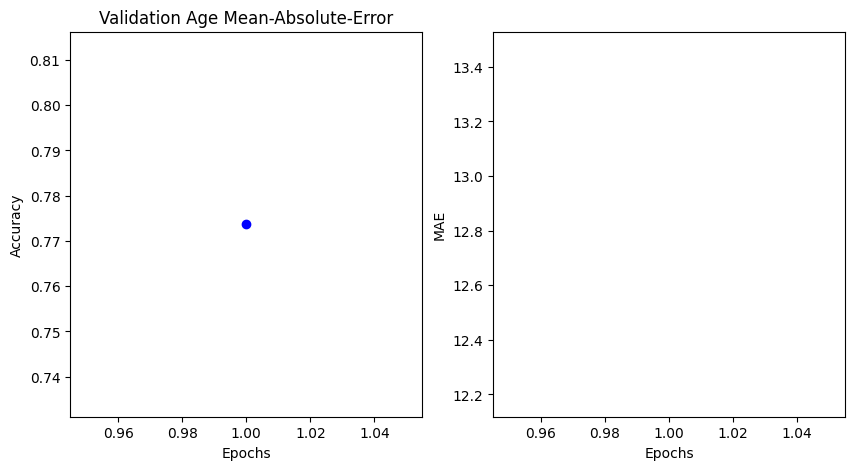

In [150]:
cpu_val_gender_accuracies=[t.to('cpu') for t in val_gender_accuracies]
cpu_val_age_maes=[t.to('cpu') for t in val_age_maes]
epochs_array = np.arange(1,(epochs+1))
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax = ax.flat
ax[0].plot(epochs_array, cpu_val_gender_accuracies, 'bo')
ax[1].plot(epochs_array, cpu_val_age_maes, 'r')
ax[0].set_xlabel('Epochs') ; ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy'); ax[1].set_ylabel('MAE')
ax[0].set_title('Validation Gender Accuracy')
ax[0].set_title('Validation Age Mean-Absolute-Error')
plt.show()


In [180]:
import pathlib
from pathlib import Path

model_path=Path("model_dict.pt")
torch.save(model.state_dict(),model_path)

In [ ]:
model_1,_,__=get_model()
model_1.load_state_dict(torch.load(model_path))
model_1

In [ ]:
img=cv2.imread("/content/test_1.png")
img=trn.preprocess_image(img).to(device)

model.eval()
gender,age,race=model(img)

pred_gender=gender.to('cpu').detach().numpy()
pred_age=age.to('cpu').detach().numpy()
pred_race=age.to('cpu').squeeze(0).detach().numpy().item()
pred_race=np.round(pred_race, decimals=1)*10
pred_race=int(pred_race)


img=cv2.imread("/content/test_1.png")
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(f"Prediction: ")
print('predicted gender:',np.where(pred_gender[0][0]<0.5, 'Female','Male'),
      '; Predicted age: ', int(pred_age[0][0]*80),
      '; Predicted race: ', races[pred_race])
plt.imshow(img)